In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
NB_USERS = 5000
FEAT_USER = 3
NB_ITEMS = 100
FEAT_ITEM = 6

NB_EPOCHS = 500
LAMBDA_REG = 1e-5
# LAMBDA_REG = 0
# learning_rate = 0.001

In [3]:
# Load data
users = pd.read_csv('data/sushi/sushi3.udata', sep='\t', names=('uid', 'gender', 'age', 'time', 'old_prefecture', 'old_region', 'old_eastwest', 'prefecture', 'region', 'eastwest', 'same'))
items = pd.read_csv('data/sushi/sushi3.idata', sep='\t', names=('iid', 'name', 'style', 'major', 'minor', 'heaviness', 'frequency', 'price', 'popularity'))
R = pd.read_csv('data/sushi/sushi3b.5000.10.score', sep=' ', header=None)
triplets = []
for i, line in enumerate(np.array(R)):
    for j, v in enumerate(line):
        if v != -1:
            triplets.append((i, j, v))
df_ratings = pd.DataFrame(triplets, columns=('user', 'item', 'rating'))
train, test = train_test_split(df_ratings, test_size=0.2, shuffle=True)

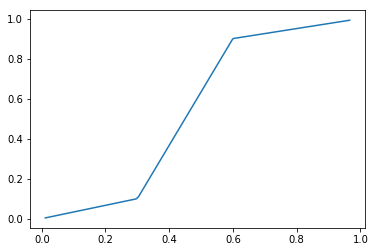

In [4]:
# Synthetic data
# x in (0,1)
# y in (0,1)
# preciser x0, x1, y0 et y1 => les parametres de la fonction s'en déduisent
# piecewise linear function (used in the partial value function )
def piecewise_linear(x, x0, x1, y0, y1):
    condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
    funclist = [lambda x: (y0/x0)*x , lambda x: ((y1-y0)/(x1-x0))*(x-x0) + y0, lambda x: ((1-y1)/(1-x1))*(x-x1) + y1]
    return np.piecewise(x, condlist, funclist)



#NB_USERS = 5000
#FEAT_USER = 3
#NB_ITEMS = 100
#FEAT_ITEM = 6

for i in range(NB_USERS)
    for j in range(FEAT_ITEM)
        

X_0 = 0.3
X_1 = 0.6
Y_0 = 0.1
Y_1 = 0.9


x = np.random.uniform(low=0.0, high=1.0, size=(100))
x.sort()
#print(x)
#print(y)
y = piecewise_linear(x, X_0, X_1, Y_0, Y_1)


#import matplotlib.pyplot as plt
#%matplotlib inline  
#plt.plot(x,y)




In [5]:
# TF
#A is not used (only the "criterion on the items" => only B)
#A = tf.constant(np.array(users[['age', 'gender', 'region']]).astype(np.float32)) 
B = tf.constant(np.array(items[['style', 'major','heaviness', 'frequency', 'price', 'popularity']]).astype(np.float32))

weights = tf.get_variable('W', shape=[NB_USERS, FEAT_ITEM], dtype=np.float32, initializer=tf.truncated_normal_initializer(stddev=1))

alpha = tf.get_variable("alpha", shape=[FEAT_ITEM],
                            initializer=tf.truncated_normal_initializer(stddev=1))
beta = tf.get_variable("beta", shape=[FEAT_ITEM],
                            initializer=tf.truncated_normal_initializer(stddev=1))
user_bias = tf.get_variable("user_bias", shape=[NB_USERS],
                            initializer=tf.truncated_normal_initializer(stddev=1))
#item_bias = tf.get_variable("item_bias", shape=[NB_ITEMS],
#                            initializer=tf.truncated_normal_initializer(stddev=1))

user_batch = tf.placeholder(tf.int32, shape=[None])
item_batch = tf.placeholder(tf.int32, shape=[None])
rate_batch = tf.placeholder(tf.float32, shape=[None])


bias_users = tf.nn.embedding_lookup(user_bias, user_batch)
#bias_items = tf.nn.embedding_lookup(item_bias, item_batch)
weight_users = tf.nn.embedding_lookup(weights, user_batch)

#beta_crit = tf.nn.embedding_lookup(item_bias, item_batch)
#alpha_crit = tf.nn.embedding_lookup(user_bias, user_batch)

feat_items = tf.nn.embedding_lookup(B, item_batch)
#feat_users = tf.nn.embedding_lookup(A, user_batch)

pred =(tf.reduce_sum(tf.multiply(tf.nn.softmax(tf.multiply(feat_items, alpha)+beta),weight_users),1) + bias_users)
       #s+bias_items)

cost_l2 = tf.losses.mean_squared_error(rate_batch, pred)

regularizer=tf.nn.l2_loss(weight_users)

#l2_user = tf.nn.l2_loss(weight_users)
#l2_item = tf.nn.l2_loss(weight_items)
#l2_bias_user = tf.nn.l2_loss(bias_users)
#l2_bias_item = tf.nn.l2_loss(bias_items)
#regularizer = tf.add(l2_user, l2_item)
#regularizer = tf.add(regularizer, l2_bias_user)
#regularizer = tf.add(regularizer, l2_bias_item)
# regularizer = tf.nn.l2_loss(M)
penalty = tf.constant(LAMBDA_REG, dtype=tf.float32, shape=[])
cost = tf.add(cost_l2, tf.multiply(regularizer, penalty))

In [6]:
global_step = tf.train.get_global_step()
train_op = tf.train.AdamOptimizer(0.1).minimize(cost, global_step=global_step)

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(NB_EPOCHS):
        _, train_pred, train_mse, reg, pen, train_cost = sess.run([train_op, pred, cost_l2, regularizer, penalty, cost], feed_dict={
            user_batch: train['user'],
            item_batch: train['item'],
            rate_batch: train['rating']
        })
        test_pred, test_mse = sess.run([pred, cost_l2], feed_dict={
            user_batch: test['user'],
            item_batch: test['item'],
            rate_batch: test['rating']
        })
        print('train rmse', train_mse ** 0.5, 'test rmse', test_mse ** 0.5)
        # print('reg', reg, 'full cost', train_cost)
        
    #print(weights.eval(session=sess))
    W_mat=weights.eval(session=sess)
    alpha_vec= alpha.eval(session=sess)
    beta_vec= beta.eval(session=sess)
    

train rmse 3.1617887639540707 test rmse 2.9872651011801756
train rmse 2.9886938670402143 test rmse 2.8202922957692595
train rmse 2.8208548322916727 test rmse 2.6588119717698744
train rmse 2.6586494827818394 test rmse 2.5037671316839605
train rmse 2.5027551727835906 test rmse 2.3553251156260937
train rmse 2.353076333483717 test rmse 2.2140613499371242
train rmse 2.2100199490505545 test rmse 2.0814167998319806
train rmse 2.0748239557433927 test rmse 1.9585568388423023
train rmse 1.9484376737568525 test rmse 1.8461265118727253
train rmse 1.8313579176002646 test rmse 1.7446852086930327
train rmse 1.7240035482356826 test rmse 1.6549056733325238
train rmse 1.6268947265695226 test rmse 1.577210567419808
train rmse 1.5403534562866372 test rmse 1.5115674951079245
train rmse 1.4644836797042557 test rmse 1.4575845521771988
train rmse 1.3992612320048912 test rmse 1.4144432440462402
train rmse 1.3443368029699017 test rmse 1.3809510541856278
train rmse 1.2989453255686045 test rmse 1.3558976871635338

train rmse 0.7545042285358303 test rmse 1.50426837475132
train rmse 0.7529145670954597 test rmse 1.5068031846428238
train rmse 0.7511148511455213 test rmse 1.5090300234872362
train rmse 0.7493787815358098 test rmse 1.5109075691233007
train rmse 0.7479440404262209 test rmse 1.513204785543564
train rmse 0.7462331032557346 test rmse 1.5154846755674842
train rmse 0.7448718465759749 test rmse 1.517386366660426
train rmse 0.7434396721454203 test rmse 1.5197787438780779
train rmse 0.7420007169493839 test rmse 1.5221280461359412
train rmse 0.7408064591761622 test rmse 1.523870475080805
train rmse 0.7394527848409685 test rmse 1.5261962170071732
train rmse 0.7382691801184542 test rmse 1.528777013432409
train rmse 0.7371503857967958 test rmse 1.5305322794558829
train rmse 0.7359473663122269 test rmse 1.5325711059254012
train rmse 0.734933316261444 test rmse 1.535263873106085
train rmse 0.7338855410913497 test rmse 1.5372535414990725
train rmse 0.7328379352116526 test rmse 1.539078455808392
train 

train rmse 0.6950300693182057 test rmse 1.7808109880163232
train rmse 0.6948422545547125 test rmse 1.7800409329454832
train rmse 0.6943359804220495 test rmse 1.780634455818089
train rmse 0.6942534793441012 test rmse 1.7848847765023979
train rmse 0.6944355524341532 test rmse 1.784172605136121
train rmse 0.6943005259050754 test rmse 1.7853317341435293
train rmse 0.693957283223836 test rmse 1.7887840887269664
train rmse 0.6938388080287773 test rmse 1.788131738281354
train rmse 0.6939006787845026 test rmse 1.7899157892163424
train rmse 0.6938337181028237 test rmse 1.7928133629179592
train rmse 0.6936017969278688 test rmse 1.7920326997506792
train rmse 0.6934317967376727 test rmse 1.794226842893723
train rmse 0.6934347622143893 test rmse 1.7967257893848467
train rmse 0.6934190536390396 test rmse 1.7961316768828237
train rmse 0.6932378098206746 test rmse 1.7984759289358503
train rmse 0.6930576796383395 test rmse 1.8003726255643158
train rmse 0.6930163327366302 test rmse 1.8001755628798934
tr

train rmse 0.685337088892192 test rmse 1.9250943272256638
train rmse 0.6852927321032621 test rmse 1.9240206394595367
train rmse 0.6852242778555624 test rmse 1.925791216160983
train rmse 0.6851502491112947 test rmse 1.9259463968710566
train rmse 0.6850769736556215 test rmse 1.9261932241896353
train rmse 0.6850131530264654 test rmse 1.9278717146690092
train rmse 0.6849613569316554 test rmse 1.9268370668610293
train rmse 0.6849190861534341 test rmse 1.9294123279654174
train rmse 0.6848836880804875 test rmse 1.9279229749196154
train rmse 0.6848509426901134 test rmse 1.9305093845118584
train rmse 0.6848210679549065 test rmse 1.9293850186764094
train rmse 0.6847924757642138 test rmse 1.9313036988332712
train rmse 0.684768756831004 test rmse 1.9310611052245876
train rmse 0.684748758303076 test rmse 1.9319380019252899
train rmse 0.6847388349864462 test rmse 1.932856317021932
train rmse 0.6847424039151272 test rmse 1.9324539061621957
train rmse 0.6847685174614355 test rmse 1.9348364949700703
tr

In [7]:
print(W_mat)
print(alpha_vec)
print(beta_vec)

[[ 1.066331    1.9173399  -1.864329   -2.9763763   1.0018115  -3.957121  ]
 [-0.05180632  1.7177396   3.3304186   2.580505    0.12303312  1.479994  ]
 [ 1.0941166   1.3709662  -0.09860156  3.6763618   1.7377232   1.5315199 ]
 ...
 [ 0.82717294 -0.38746685  0.5889197   3.9532263   1.343571   -1.6000885 ]
 [ 4.504394    2.0626862   1.8114731   3.2950892  -3.4091275   1.5208752 ]
 [-0.9323296   1.3489004   1.5469805   3.4738061   2.5705705   2.968796  ]]
[ 4.196883   6.4330873  1.8368745  2.8925083  1.9433355 -1.2747475]
[0.8099757  0.78845453 0.52409124 0.4283868  0.06774634 0.42456144]


In [8]:
#import matplotlib.pyplot as plt
#plt.imshow(W_mat)

# add some prints/visualisation
# check encoding B
# positivity on W 

In [ ]:
# TODO => comparer avec SVD++ / baseline constante (predire la moyenne des ratins)
# pourquoi le modele bilineaire n'était pas convaicant ?